# Dataset of SES

## Import libraries

In [53]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from itertools import combinations
pd.set_option("display.max_rows", None)

## Util Functions

### Format Date

In [54]:

def to_date_format(df: pd.DataFrame)-> pd.DataFrame:
    df['DT_NOTIFIC'] = pd.to_datetime(
        df['DT_NOTIFIC'], dayfirst=True)
    df['DT_NASC'] = pd.to_datetime(
        df['DT_NASC'], dayfirst=True)
    return df

### CHI2_Function

In [55]:

def chi2_function(vars: list[str], df: pd.DataFrame,order_by: str = 'chi2')-> None:
    results = []

    for var1, var2 in combinations(vars, 2):
        tabela = pd.crosstab(df[var1], df[var2])
        
        chi2, p, _, _ = chi2_contingency(tabela)
        results.append({
            'var1': var1,
            'var2': var2,
            'chi2': chi2,
            'association': '✅ Yes' if p < 0.05 else '❌ No'
        })

    # Exibir resultados ordenados por p-valor
    df_results = pd.DataFrame(results).sort_values(by=order_by)
    print(df_results)

## Read data

In [56]:
path = "../data/raw/notifications_ses"

files = [f for f in os.listdir(path) if f.endswith('.csv')]

dfs = [to_date_format(pd.read_csv(os.path.join(path, file), sep=';'))
       for file in files]


main = pd.concat(dfs, ignore_index=True)

main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388441 entries, 0 to 388440
Data columns (total 16 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   DT_NOTIFIC  388441 non-null  datetime64[ns]
 1   DT_NASC     382825 non-null  datetime64[ns]
 2   NU_IDADE_N  388412 non-null  float64       
 3   CS_SEXO     388441 non-null  object        
 4   CS_RACA     382695 non-null  object        
 5   ID_MN_RESI  387495 non-null  object        
 6   LOCAL_OCOR  378460 non-null  object        
 7   OUT_VEZES   375551 non-null  object        
 8   LES_AUTOP   374831 non-null  object        
 9   VIOL_FISIC  377456 non-null  object        
 10  VIOL_PSICO  372815 non-null  object        
 11  VIOL_SEXU   372320 non-null  object        
 12  NUM_ENVOLV  373440 non-null  object        
 13  AUTOR_SEXO  376925 non-null  object        
 14  ORIENT_SEX  310969 non-null  object        
 15  IDENT_GEN   310969 non-null  object        
dtypes:

### Rename colums and create a copy

In [57]:
column_mapping = {
    'DT_NOTIFIC': 'notification_date',
    'DT_NASC': 'birth_date',
    'NU_IDADE_N': 'age',
    'CS_SEXO': 'sex',
    'CS_RACA': 'race',
    'ID_MN_RESI': 'city_residence',
    'LOCAL_OCOR': 'occurrence_place',
    'OUT_VEZES': 'previous_occurrences',
    'LES_AUTOP': 'self_harm',
    'VIOL_FISIC': 'physical_violence',
    'VIOL_PSICO': 'psychological_violence',
    'VIOL_SEXU': 'sexual_violence',
    'NUM_ENVOLV': 'num_perpetrators',
    'AUTOR_SEXO': 'perpetrator_sex',
    'ORIENT_SEX': 'sexual_orientation',
    'IDENT_GEN': 'gender_identity'
}

main = main.rename(columns=column_mapping)

df_cleaned = main.copy()

main.head()


,notification_date,birth_date,age,sex,race,city_residence,occurrence_place,previous_occurrences,self_harm,physical_violence,psychological_violence,sexual_violence,num_perpetrators,perpetrator_sex,sexual_orientation,gender_identity
0,2010-08-03,1937-11-02,72.0,Feminino,Parda,Governador Valadares,Residencia,Sim,Não,Sim,Sim,Não,Um,Masculino,NaN,NaN
1,2010-02-07,1992-04-30,17.0,Feminino,Parda,Montes Claros,Residencia,Ignorado,Não,Sim,Sim,NaN,Um,Masculino,NaN,NaN
2,2010-06-28,2003-04-07,7.0,Feminino,Ignorado,Governador Valadares,Ignorado,Ignorado,Não,Não,Sim,Sim,Um,Masculino,NaN,NaN
3,2010-01-07,1963-05-07,46.0,Feminino,Parda,São José do Goiabal,Residencia,Ignorado,NaN,Não,Não,Não,Um,Feminino,NaN,NaN
4,2010-05-20,1917-08-01,92.0,Feminino,Branca,Jaboticatubas,Residencia,Sim,NaN,Não,Não,Não,Dois ou mais,Masculino,NaN,NaN


## Analisy Variables

### Numerics

#### Age

In [58]:
main['age'].describe()

count    388412.000000
mean         30.104054
std          15.937374
min          -1.000000
25%          18.000000
50%          28.000000
75%          39.000000
max         121.000000
Name: age, dtype: float64

In [59]:
main['age'] = main['notification_date'].dt.year - main['birth_date'].dt.year
main['age'].describe()

count    382825.000000
mean         30.624823
std          15.935542
min           0.000000
25%          19.000000
50%          28.000000
75%          40.000000
max         122.000000
Name: age, dtype: float64

<Axes: ylabel='age'>

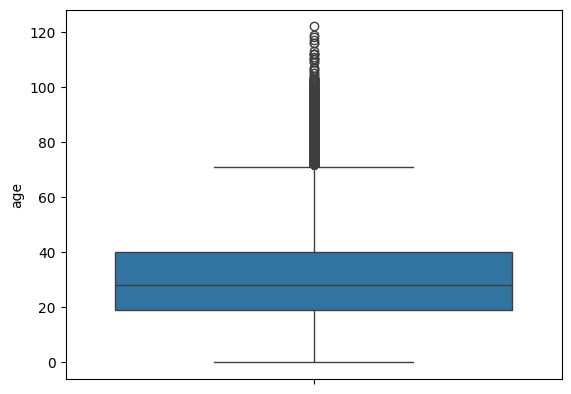

In [60]:
main['age'] = pd.to_numeric(main['age'], errors='coerce').astype('Int64')
sns.boxplot(data=main, y='age')

In [61]:
main['age'].unique()

<IntegerArray>
[ 73,  18,   7,  47,  93,   0,  11,  55,  30,  25,
 ...
 116, 112, 117, 107, 104, 106, 119, 111, 122, 118]
Length: 119, dtype: Int64

In [62]:
# Remover outliers de 'age' utilizando o método do Intervalo Interquartil (IQR)
Q1 = main['age'].quantile(0.25)
Q3 = main['age'].quantile(0.75)

IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_cleaned = df_cleaned[(df_cleaned['age'] >= lower_bound) & (df_cleaned['age'] <= upper_bound)]

<Axes: ylabel='age'>

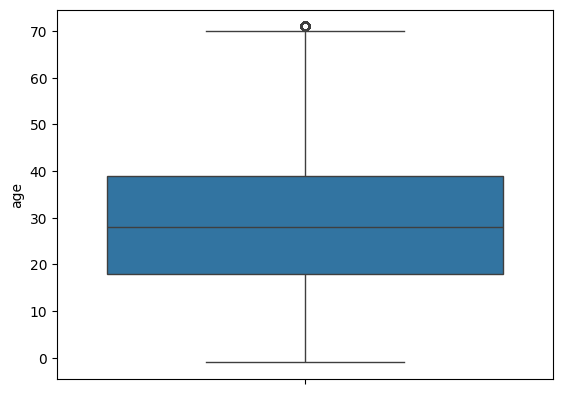

In [63]:
sns.boxplot(data=df_cleaned, y='age')

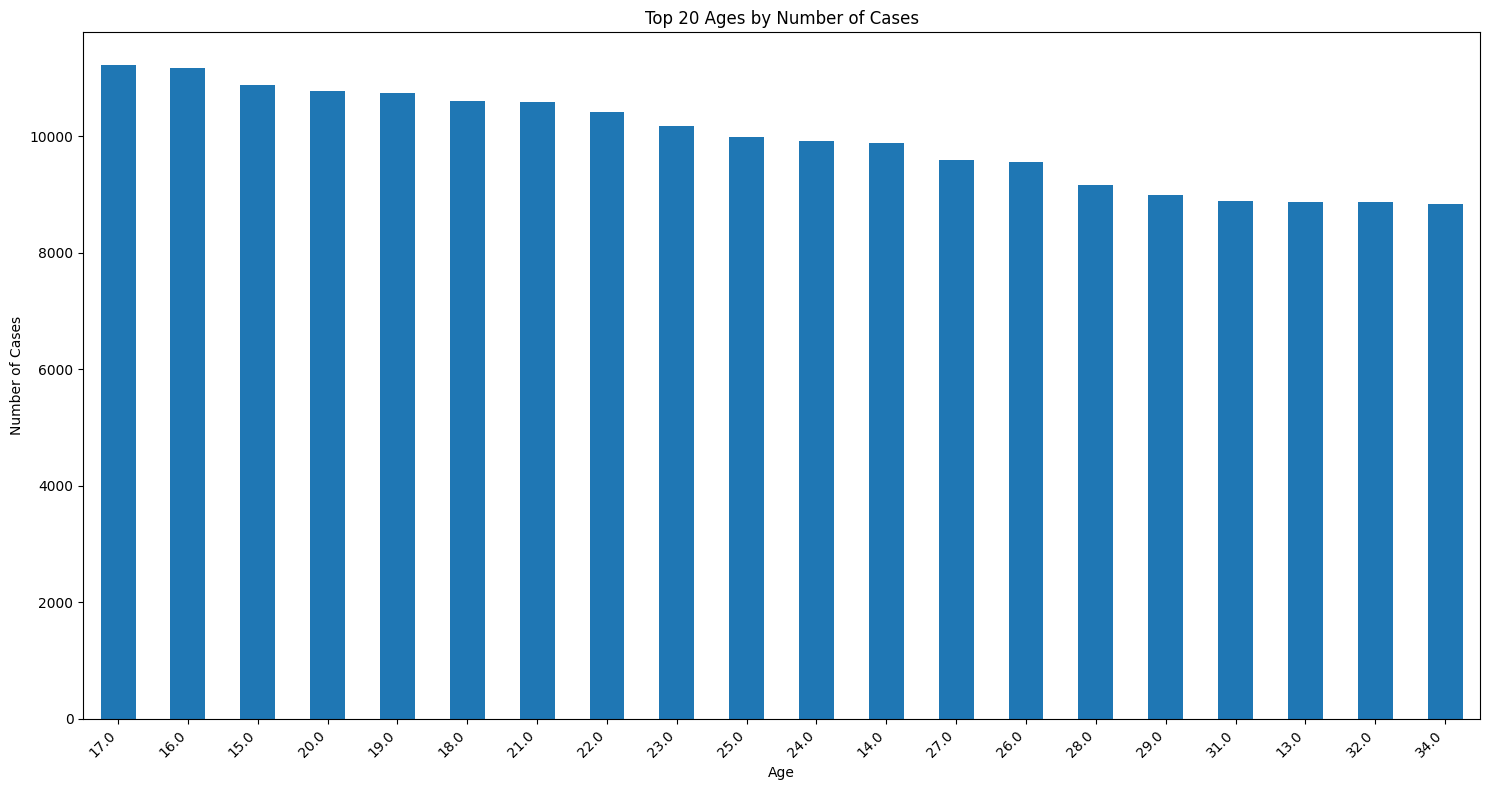

In [64]:
# Get value counts and create a bar plot
plt.figure(figsize=(15, 8))
age_counts = df_cleaned['age'].value_counts().head(20)
age_counts.plot(kind='bar')
plt.title('Top 20 Ages by Number of Cases')
plt.xlabel('Age')
plt.ylabel('Number of Cases')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

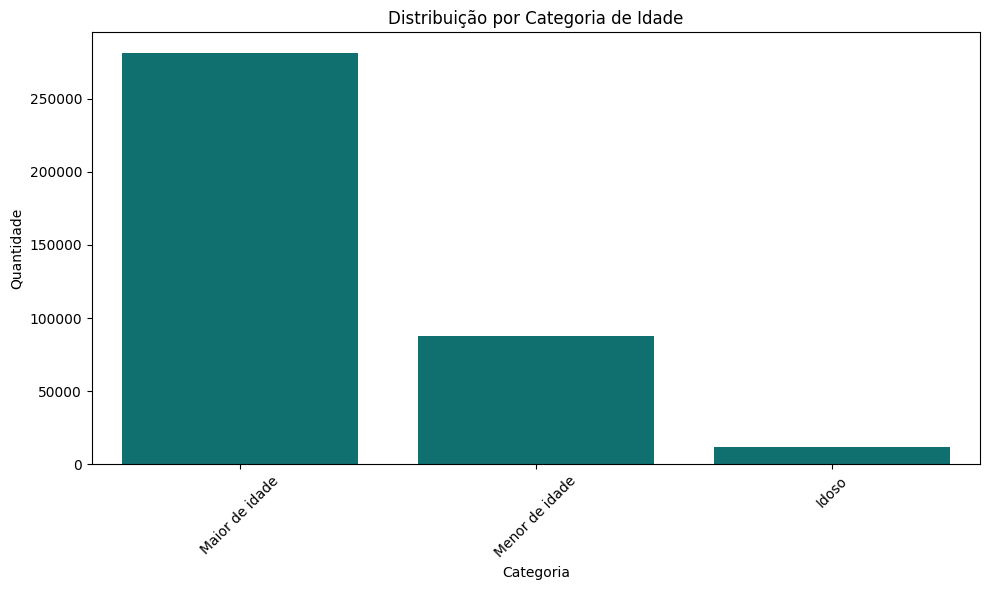

In [65]:
def categorize_age(age):
    if age < 18:
        return 'Menor de idade'
    elif age < 60:
        return 'Maior de idade'
    else:
        return 'Idoso'

df_cleaned['age_category'] = df_cleaned['age'].apply(categorize_age)

main['age_category'] = main['age'].apply(categorize_age)

plt.figure(figsize=(10, 6))
sns.countplot(
    data=df_cleaned,
    x='age_category',
    order=df_cleaned['age_category'].value_counts().index,
    color='teal'
)
plt.title('Distribuição por Categoria de Idade')
plt.xlabel('Categoria')
plt.ylabel('Quantidade')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Notification Date

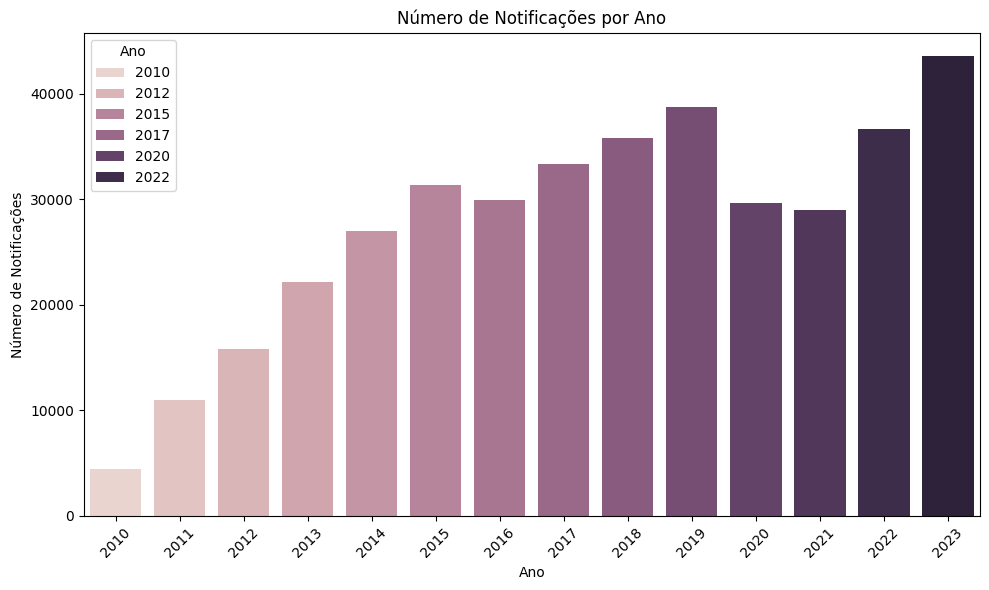

In [66]:
yearly_counts = main['notification_date'].dt.year.value_counts().sort_index()

# Criação do DataFrame auxiliar para facilitar a plotagem com o seaborn
yearly_counts_df = yearly_counts.reset_index()
yearly_counts_df.columns = ['Ano', 'Número de Notificações']

plt.figure(figsize=(10, 6))

# Usando uma paleta agradável ('crest' é ótima para esse tipo de dado)
sns.barplot(
    data=yearly_counts_df,
    x='Ano',
    y='Número de Notificações',
    hue='Ano'
)

plt.title('Número de Notificações por Ano')
plt.xlabel('Ano')
plt.ylabel('Número de Notificações')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<Axes: title={'center': 'Distribuição por Ano de Notificação'}, xlabel='notification_date'>

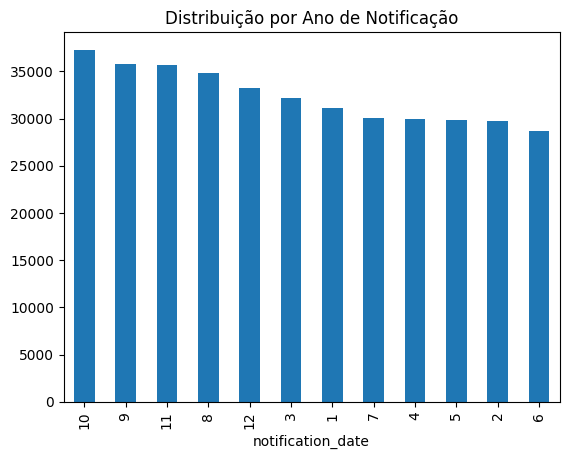

In [67]:
main['notification_date'].dt.month.value_counts().plot(kind='bar', title='Distribuição por Ano de Notificação')

# Baseado nas datas verificar os feriados e finais de semana para analise de acontecimentos.

### Categorics

#### Describe

In [68]:
main.drop(columns=['notification_date', 'birth_date', 'age']).describe()

,sex,race,city_residence,occurrence_place,previous_occurrences,self_harm,physical_violence,psychological_violence,sexual_violence,num_perpetrators,perpetrator_sex,sexual_orientation,gender_identity,age_category
count,388441,382695,387495,378460,375551,374831,377456,372815,372320,373440,376925,310969,310969,388441
unique,1,6,853,10,3,3,3,3,3,3,4,5,5,3
top,Feminino,Parda,Belo Horizonte,Residencia,Não,Não,Sim,Não,Não,Um,Masculino,Heterossexual,Não se aplica,Maior de idade
freq,388441,170142,28158,263840,158391,249030,276330,246949,319796,283563,203255,180603,202642,282139


#### Test CHI2

In [69]:
vars = main.select_dtypes(include=['object']).columns.tolist()

filtered_vars = [v for v in vars if main[v].nunique() > 1]
chi2_function(filtered_vars, main)


                      var1                    var2           chi2 association
11                    race            age_category     930.166852       ✅ Yes
41    previous_occurrences            age_category     935.805623       ✅ Yes
71        num_perpetrators            age_category     973.365835       ✅ Yes
55       physical_violence         gender_identity    1393.379788       ✅ Yes
4                     race       physical_violence    1867.687890       ✅ Yes
49               self_harm            age_category    1964.178677       ✅ Yes
62  psychological_violence            age_category    2064.818537       ✅ Yes
34    previous_occurrences       physical_violence    2190.697296       ✅ Yes
77         gender_identity            age_category    2538.050346       ✅ Yes
74         perpetrator_sex            age_category    3169.760238       ✅ Yes
61  psychological_violence         gender_identity    4134.226111       ✅ Yes
66         sexual_violence         gender_identity    6144.46673

#### Sex

<Axes: title={'center': 'Distribuição por Sexo'}, xlabel='sex'>

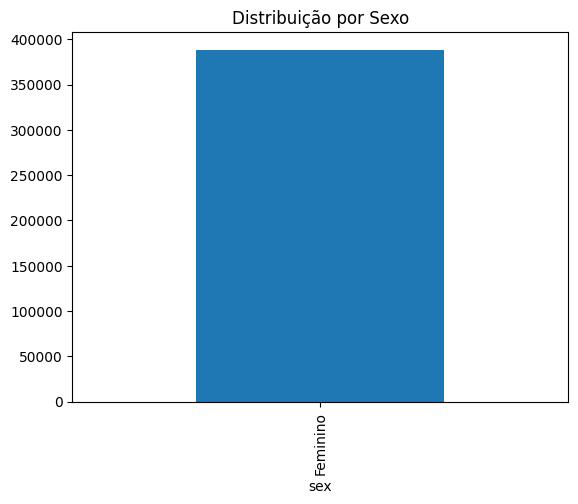

In [70]:
main['sex'].value_counts().plot(kind='bar', title='Distribuição por Sexo')


In [71]:
# Por possui somente uma categoria, e não passar no teste de qui-quadrado se faz necessário remover
df_cleaned.drop(columns=['sex'],inplace=True)

#### Race

<Axes: title={'center': 'Distribuição por Raça'}, xlabel='race'>

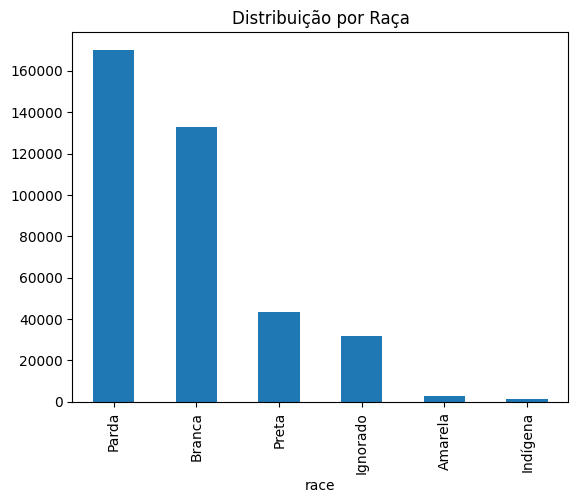

In [72]:
main['race'].value_counts().plot(kind='bar', title='Distribuição por Raça')

#### City Residence

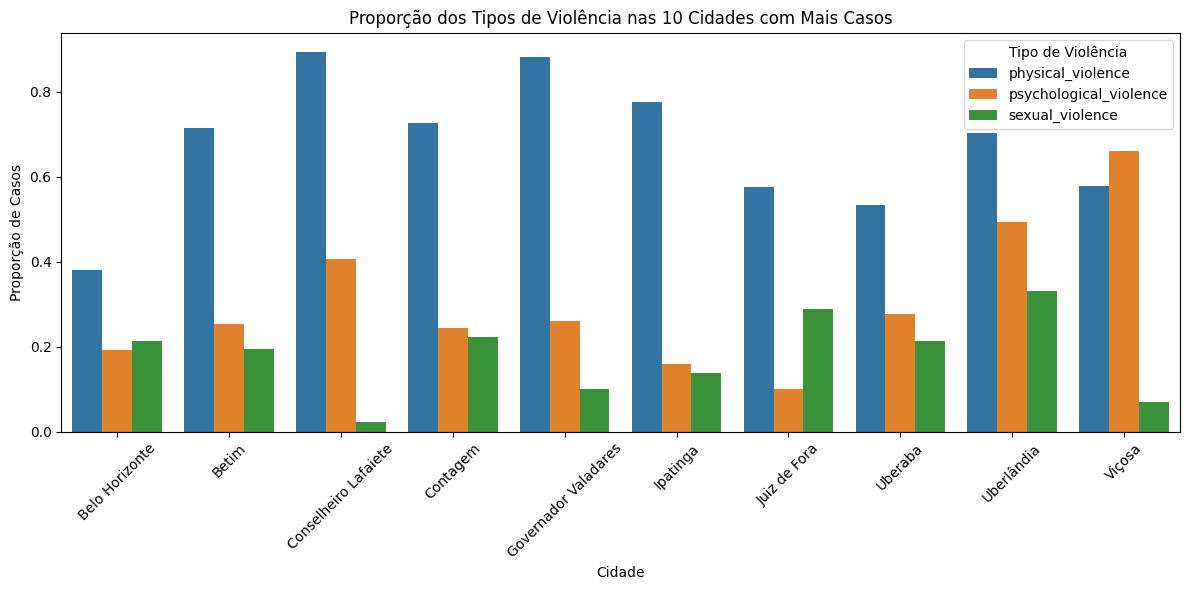

In [94]:

top_10_cities = main['city_residence'].value_counts().head(10).index
df_top_cities = main[main['city_residence'].isin(top_10_cities)]
violence_props = df_top_cities.groupby('city_residence')[['physical_violence', 'psychological_violence', 'sexual_violence']].apply(
    lambda x: (x == 'Sim').mean()
).reset_index()
melted_props = violence_props.melt(id_vars='city_residence', var_name='Tipo de Violência', value_name='Proporção')

plt.figure(figsize=(12, 6))
sns.barplot(
    data=melted_props,
    x='city_residence',
    y='Proporção',
    hue='Tipo de Violência'
)
plt.title('Proporção dos Tipos de Violência nas 10 Cidades com Mais Casos')
plt.xlabel('Cidade')
plt.ylabel('Proporção de Casos')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [74]:
city_categories = main['city_residence'].dropna().unique()
print(f"Total of cities: {len(city_categories)}")

Total of cities: 853


#### Gender Identity

<Axes: title={'center': 'Distribuição por Identidade de Gênero'}, xlabel='gender_identity'>

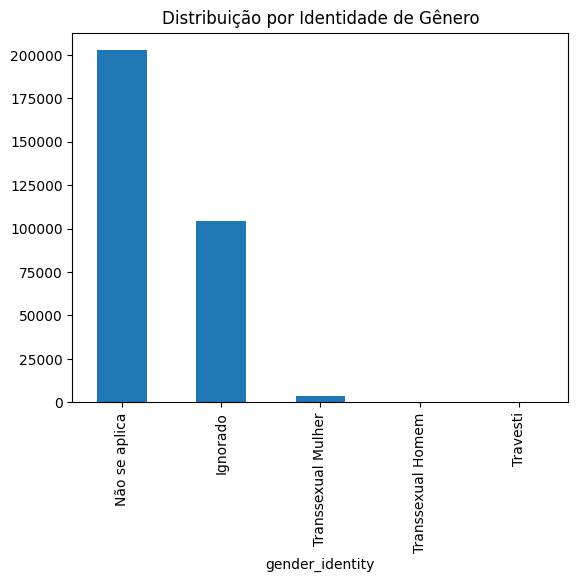

In [75]:
main['gender_identity'].value_counts().plot(kind='bar', title='Distribuição por Identidade de Gênero')

#### Occurrence Place

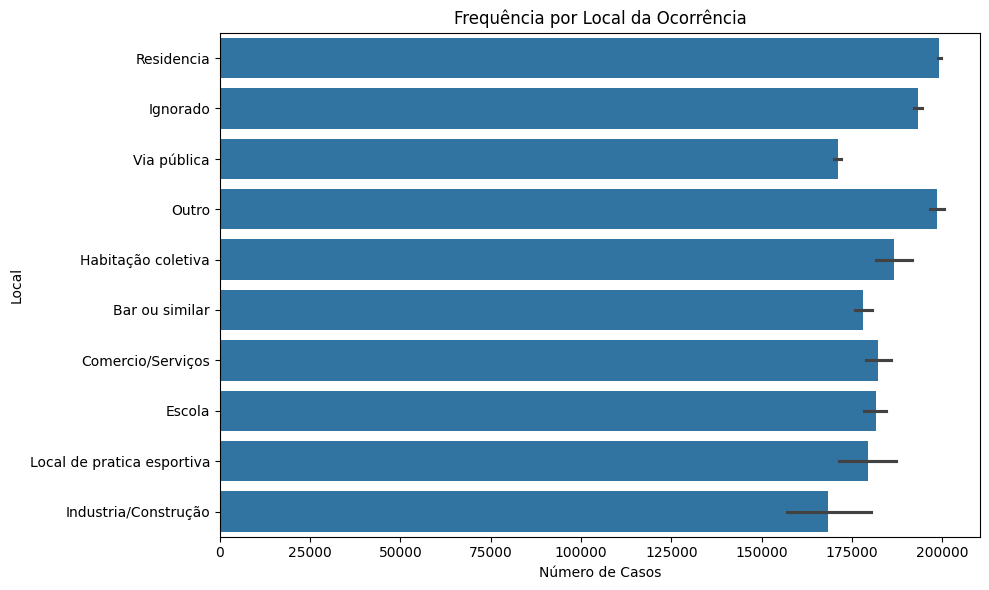

In [89]:
plt.figure(figsize=(10, 6))
sns.barplot(y=main['occurrence_place'].values, x=main['occurrence_place'].index)
plt.title('Frequência por Local da Ocorrência')
plt.xlabel('Número de Casos')
plt.ylabel('Local')
plt.tight_layout()
plt.show()

#### Previous Occurrences

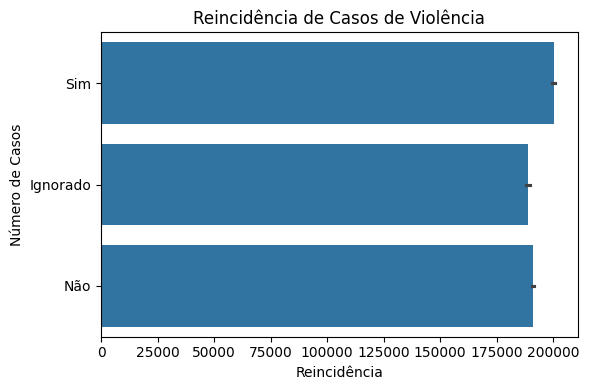

In [90]:
plt.figure(figsize=(6, 4))
sns.barplot(x=main['previous_occurrences'].index, y=main['previous_occurrences'].values)
plt.title('Reincidência de Casos de Violência')
plt.xlabel('Reincidência')
plt.ylabel('Número de Casos')
plt.tight_layout()
plt.show()

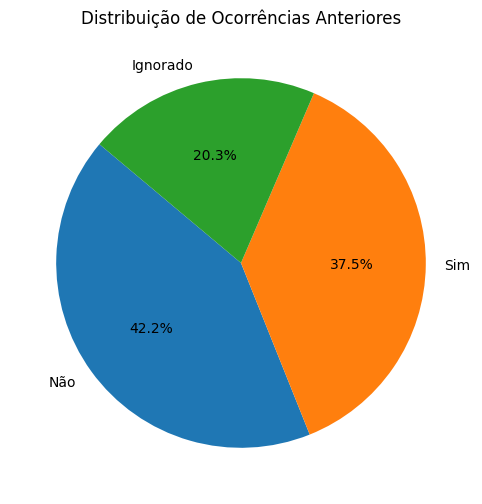

In [78]:
plt.figure(figsize=(10, 6))
plt.pie(main['previous_occurrences'].value_counts(),
        labels=main['previous_occurrences'].value_counts().index,
        autopct='%1.1f%%',
        startangle=140)
plt.title('Distribuição de Ocorrências Anteriores')
plt.show()

#### Self Harm

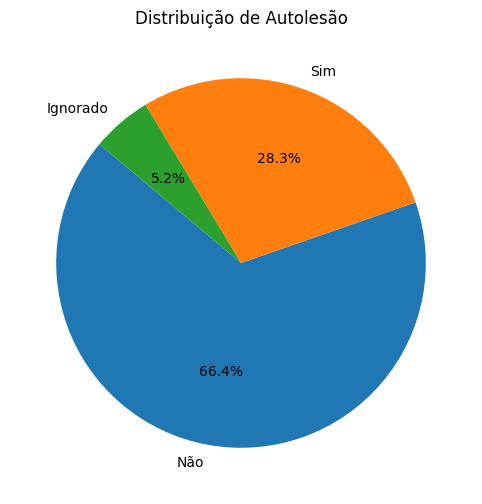

In [79]:
plt.figure(figsize=(10, 6))
plt.pie(main['self_harm'].value_counts(),
        labels=main['self_harm'].value_counts().index,
        autopct='%1.1f%%',
        startangle=140)
plt.title('Distribuição de Autolesão')
plt.show()

#### Physical Violence

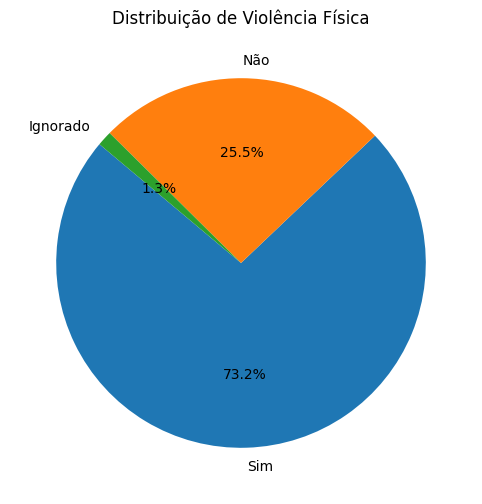

In [80]:
plt.figure(figsize=(10, 6))
plt.pie(main['physical_violence'].value_counts(),
        labels=main['physical_violence'].value_counts().index,
        autopct='%1.1f%%',
        startangle=140)
plt.title('Distribuição de Violência Física')
plt.show()

#### Psychological Violence

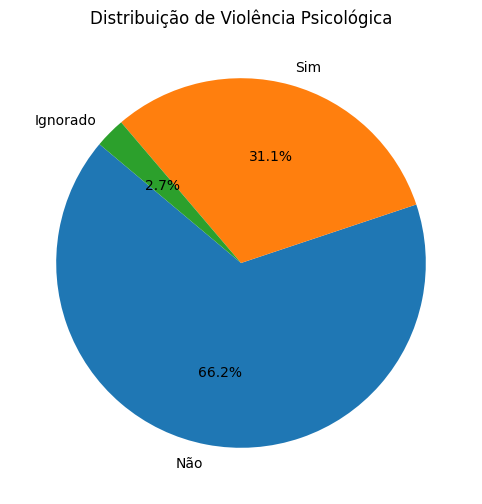

In [81]:
plt.figure(figsize=(10, 6))
plt.pie(main['psychological_violence'].value_counts(),
        labels=main['psychological_violence'].value_counts().index,
        autopct='%1.1f%%',
        startangle=140)
plt.title('Distribuição de Violência Psicológica')
plt.show()

#### Sexual Violence

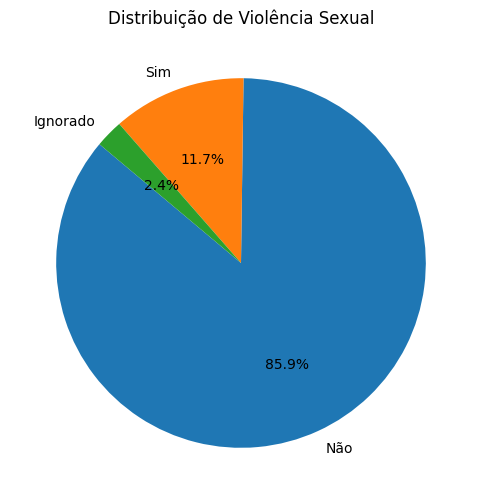

In [82]:
plt.figure(figsize=(10, 6))
plt.pie(main['sexual_violence'].value_counts(),
        labels=main['sexual_violence'].value_counts().index,
        autopct='%1.1f%%',
        startangle=140)
plt.title('Distribuição de Violência Sexual')
plt.show()

#### Num Perpetrators

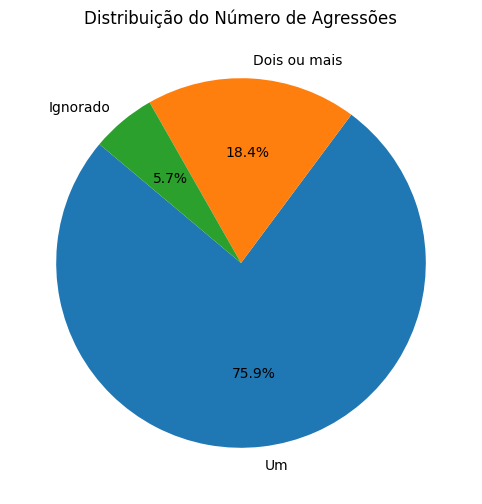

In [83]:
plt.figure(figsize=(10, 6))
plt.pie(main['num_perpetrators'].value_counts(),
        labels=main['num_perpetrators'].value_counts().index,
        autopct='%1.1f%%',
        startangle=140)
plt.title('Distribuição do Número de Agressões')
plt.show()

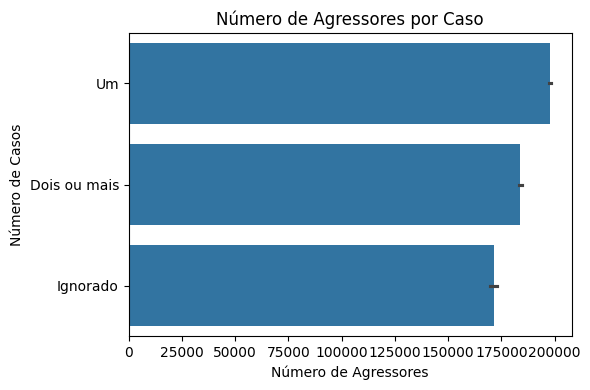

In [92]:
plt.figure(figsize=(6, 4))
sns.barplot(x=main['num_perpetrators'].index, y=main['num_perpetrators'].values)
plt.title('Número de Agressores por Caso')
plt.xlabel('Número de Agressores')
plt.ylabel('Número de Casos')
plt.tight_layout()
plt.show()

#### Perpetrator Sex

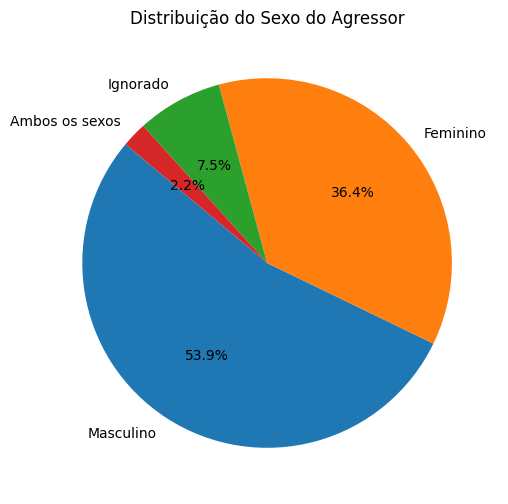

In [84]:
plt.figure(figsize=(10, 6))
plt.pie(main['perpetrator_sex'].value_counts(),
        labels=main['perpetrator_sex'].value_counts().index,
        autopct='%1.1f%%',
        startangle=140)
plt.title('Distribuição do Sexo do Agressor')
plt.show()

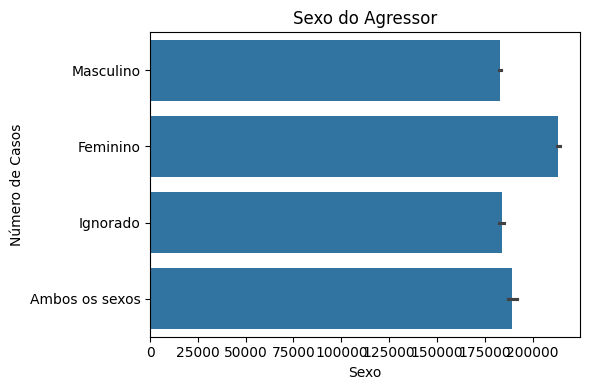

In [91]:
plt.figure(figsize=(6, 4))
sns.barplot(x=main['perpetrator_sex'].index, y=main['perpetrator_sex'].values)
plt.title('Sexo do Agressor')
plt.xlabel('Sexo')
plt.ylabel('Número de Casos')
plt.tight_layout()
plt.show()

#### Sexual Orientation

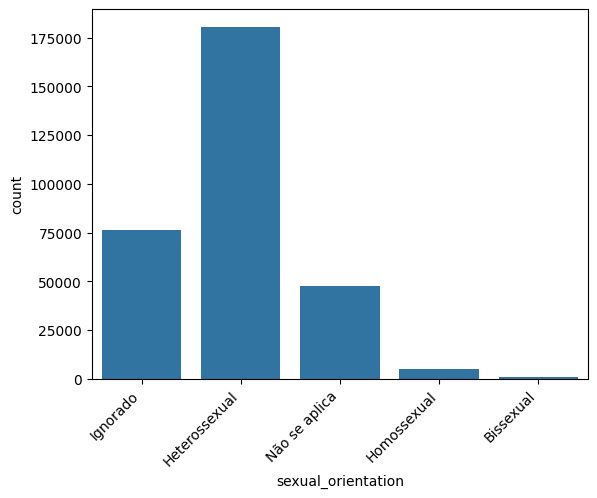

In [85]:
sns.countplot(data=main, x='sexual_orientation')
plt.xticks(rotation=45, ha='right')
plt.show()

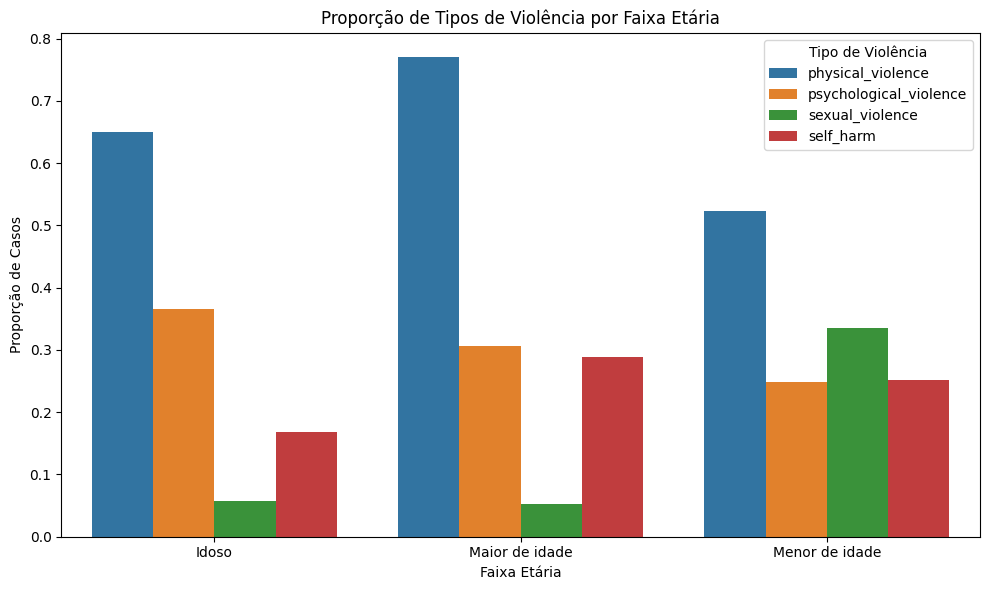

In [86]:
age_violence_reset = main.groupby('age_category')[['physical_violence', 'psychological_violence', 'sexual_violence', 'self_harm']].apply(
    lambda x: (x == 'Sim').sum() / x.shape[0]
).reset_index()

# Derreter o DataFrame para facilitar o uso com seaborn
melted_violence = age_violence_reset.melt(id_vars='age_category', var_name='Tipo de Violência', value_name='Proporção')

# Criar o gráfico
plt.figure(figsize=(10, 6))
sns.barplot(data=melted_violence, x='age_category', y='Proporção', hue='Tipo de Violência')
plt.title('Proporção de Tipos de Violência por Faixa Etária')
plt.xlabel('Faixa Etária')
plt.ylabel('Proporção de Casos')
plt.legend(title='Tipo de Violência')
plt.tight_layout()
plt.show()

## Save dataset cleaned

In [457]:
df_cleaned.to_csv('../data/processed/notifications_ses.csv', index=False)